# Harvard Geospatial Libraries

-----------------------------------------------

## Setting up the Notebook

### Imports

In [1]:
simport pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from geopy.geocoders import GoogleV3
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.exc import GeocoderUnavailable
from collections import Counter

### Load data

In [2]:
df = pd.read_csv('{FILE-PATH}/all-metadata.csv')
df

,GBL_version,identifier,title,description,rights,provenance,references,ID,slug,geom_type,...,publisher,format,type,subject,spatial,issued,temporal,geom,year,harvard_collection_ID
0,1.0,https://hgl.harvard.edu/catalog/harvard-g3801-...,"New York Railroads, 1857 (Raster Image)",This layer is a georeferenced raster image of ...,Public,Harvard,"{""http://www.opengis.net/cat/csw/csdgm"":""https...",mapimages_public:G3801_P3_1857_V3,harvard-g3801-p3-1857-v3,Raster,...,"['Harvard Map Collection, Harvard College Libr...",GeoTIFF,Dataset,"['Maps', 'Transportation', 'Railroads', 'Human...","['New York', 'Vermont', 'New Hampshire', 'Mass...",2007-11,['1857'],"ENVELOPE(-80.873058, -70.885706, 45.78082, 39....",1857.0,['990097248230203941']
1,1.0,https://hgl.harvard.edu/catalog/harvard-euratl...,"First-level Administrative Divisions, Europe, ...",This shapefile represents 1st-level administra...,Restricted,Harvard,"{""http://www.opengis.net/cat/csw/csdgm"":""https...",vector_restricted:EURATLAS_1ST_LEVEL_DIV_1200,harvard-euratlas-1st-level-div-1200,Polygon,...,['Euratlas-Nussli'],Shapefile,Dataset,"['Boundaries', 'Administrative and political d...",['Europe'],2010,['1200'],"ENVELOPE(3.137241, 18.533875, 54.308698, 42.3234)",1200.0,['990114771850203941']
2,1.0,https://hgl.harvard.edu/catalog/harvard-tg00ndlpy,"UA Census Landmark Polygon Features, 2000 - No...",This datalayer displays polygon landmark featu...,Public,Harvard,"{""http://www.opengis.net/cat/csw/csdgm"":""https...",vector_public:TG00NDLPY,harvard-tg00ndlpy,Polygon,...,['Euratlas-Nussli'],Shapefile,Dataset,"['transportation', 'intelligenceMilitary', 'st...",['North Dakota'],2002,['2000'],"ENVELOPE(-104.04868, -96.5851879979777, 49.000...",2000.0,['990087417150203941']
3,1.0,https://hgl.harvard.edu/catalog/harvard-tg95co...,"Census Voting Districts, 1995 - Colorado",This datalayer displays the Voting Districts t...,Public,Harvard,"{""http://www.opengis.net/cat/csw/csdgm"":""https...",vector_public:TG95COVOTPY,harvard-tg95covotpy,Polygon,...,['Euratlas-Nussli'],Shapefile,Dataset,"['boundaries', 'Census', 'Election districts',...",['Colorado'],1996,['1995'],"ENVELOPE(-109.060256, -102.041485, 41.003444, ...",1995.0,['990074179590203941']
4,1.0,https://hgl.harvard.edu/catalog/harvard-am-ams...,"Hassi Mouina region, Algeria, 1953, Army Map S...",This layer is a georeferenced raster image of ...,Public,Harvard,"{""http://www.opengis.net/cat/csw/csdgm"":""https...",mapimages_public:AM_AMS_NH3105L,harvard-am-ams-nh3105l,Raster,...,"['Harvard Map Collection, Harvard College Libr...",GeoTIFF,Dataset,"['Maps, Topographic', 'Land use', 'Infrastruct...","['Algeria', 'Mouina, Hassi']",2009,['1953'],"ENVELOPE(-0.149279, 1.823166, 31.105157, 29.78...",1953.0,['990094028330203941']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999,1.0,https://hgl.harvard.edu/catalog/harvard-vmap1t...,VMap1 Transportation Features Void Collection ...,This datalayer is a polyon coverage representi...,Public,Harvard,"{""http://www.opengis.net/cat/csw/csdgm"":""https...",vector_public:VMAP1TRAVOIDA,harvard-vmap1travoida,Polygon,...,"['Harvard Map Collection, Harvard College Libr...",Shapefile,Dataset,"['transportation', 'Void Collection Areas', 'T...","['Earth', 'Northern Hemisphere', 'Southern Hem...",NaN,['1995-2001'],"ENVELOPE(-122.498123, 140.668304, 57.86618, -5...",1995.0,['990095256130203941']
11000,1.0,https://hgl.harvard.edu/catalog/harvard-tg00aklkd,"UA Census Landmark Line Features, 2000 - Alaska",This datalayer displays landmark line features...,Public,Harvard,"{""http://www.opengis.net/cat/csw/csdgm"":""https...",vector_public:TG00AKLKD,harvard-tg00aklkd,Line,...,"['Harvard Map Collection, Harvard College Libr...",Shapefile,Dataset,"['transportation', 'Census', 'Airports', 'Land...",['Alaska'],2002,['2000'],"ENVELOPE(-176.651432013452, 173.194720005539, ...",2000.0,['990087417150203941']
11001,1.0,https://hgl.harvard.edu/catalog/harvard-g6014-...,"Brussels, Be

-----------------------------------------------

## Data Cleaning

### The problem with 'spatial' and 'subject':

In [3]:
df['spatial'][10], df['subject'][10]

("['Ohio']",
 "['boundaries', 'Census', 'Administrative divisions', 'Boundaries', 'County subdivisions', 'Minor civil divisions']")

### Fills in empty cells with empty lists represented as strings (for consistency)

In [4]:
df = df.replace(np.nan, "[\"None\"]", regex = True)

### Convert the lists represented as strings into actual lists

In [5]:
df['spatial'] = [eval(row) for row in df['spatial']]
df['subject'] = [eval(row) for row in df['subject']]

### Remove all non-alphabetic characters except for standard punctuation: , ! ? ' "

In [6]:
def clean_string(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s.,!?\'"-]', '', text)
    return cleaned_text

df['spatial'] = [[clean_string(word) for word in row] for row in df['spatial']]
df['subject'] = [[clean_string(word) for word in row] for row in df['subject']]

### So now, 'spatial' and 'subject' are lists of clean strings: 

In [7]:
df['spatial'][10], df['subject'][10]

(['Ohio'],
 ['boundaries',
  'Census',
  'Administrative divisions',
  'Boundaries',
  'County subdivisions',
  'Minor civil divisions'])

--------------------------------------------------------------------------------------------------

## Exploratory Counts and Visualizations

### A simple/naive approach to summarizing location data -- How many occurrences of each string? ('spatial')
This ignores that "Boston", "Boston, MA", and "Massachusetts" should really reflect a "MA" count of 3, not 1. But it's a good start!

In [8]:
spatial_counts = Counter([string for sublist in df['spatial'] for string in sublist])

print("Place Counts:")
for string, count in spatial_counts.items():
    print(f"{string}: {count}")

Place Counts:
New York: 180
Vermont: 136
New Hampshire: 175
Massachusetts: 1885
Rhode Island: 148
Connecticut: 151
New Jersey: 156
Pennsylvania: 144
Canada: 138
Ontario: 25
Europe: 620
North Dakota: 86
Colorado: 91
Algeria: 137
Mouina, Hassi: 1
Poland: 127
Lithuania: 66
Belarus: 12
Europe, Eastern: 19
Honduras: 90
Yoro, Departamento de: 9
Olanchito: 4
Austria: 54
Belgium: 91
Bosnia and Herzegovina: 18
Croatia: 41
Czech Republic: 68
Denmark: 55
France: 164
Germany: 302
Hungary: 27
Italy: 133
Liechtenstein: 32
Luxembourg: 31
Netherlands: 157
Romania: 28
Russia: 45
Serbia: 22
Slovakia: 23
Slovenia: 34
Sweden: 28
Switzerland: 43
United Kingdom: 164
Europe, Central: 21
Europe, Western: 7
Ohio: 119
Washington: 146
King County: 103
New England: 44
Oregon: 94
Louisiana: 117
Indiana: 112
Arizona: 85
World: 39
Malden: 32
Utah: 83
Morocco: 61
Marrakech: 1
Somalia: 40
Boston: 761
Dorchester: 122
Providence: 6
East Providence: 6
Snohomish County: 28
Pierce County: 27
Earth: 242
Northern Hemisphere:

### Counts above 50, represented in a bar plot ('spatial')

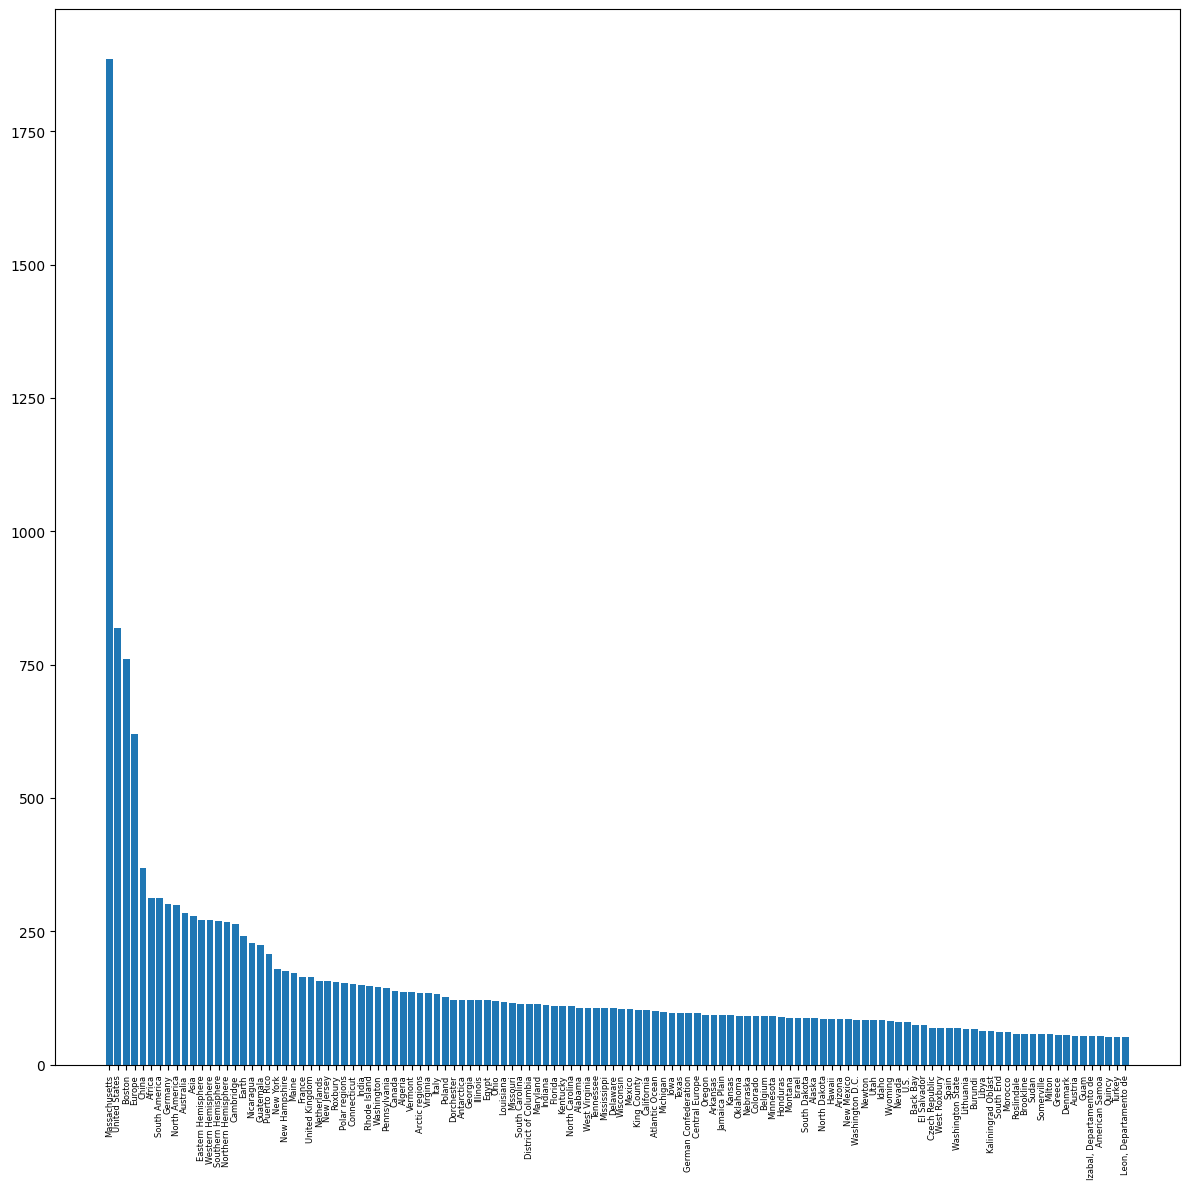

In [9]:
# Trim Counter object to make bar graph viewable
trim_threshold = 50
trimmed_spatial = Counter({key: count for key, count in spatial_counts.items() if count > trim_threshold})
sorted_spatial = sorted(trimmed_spatial.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted keys and counts
sorted_keys = [key for key, _ in sorted_spatial]
sorted_values = [value for _, value in sorted_spatial]

# Plot
plt.figure(figsize = (12, 12))
plt.bar(sorted_keys, sorted_values)
plt.xticks(rotation = 90, fontsize = 6)
plt.tight_layout()

### Zooming into the Top 10 ('spatial')

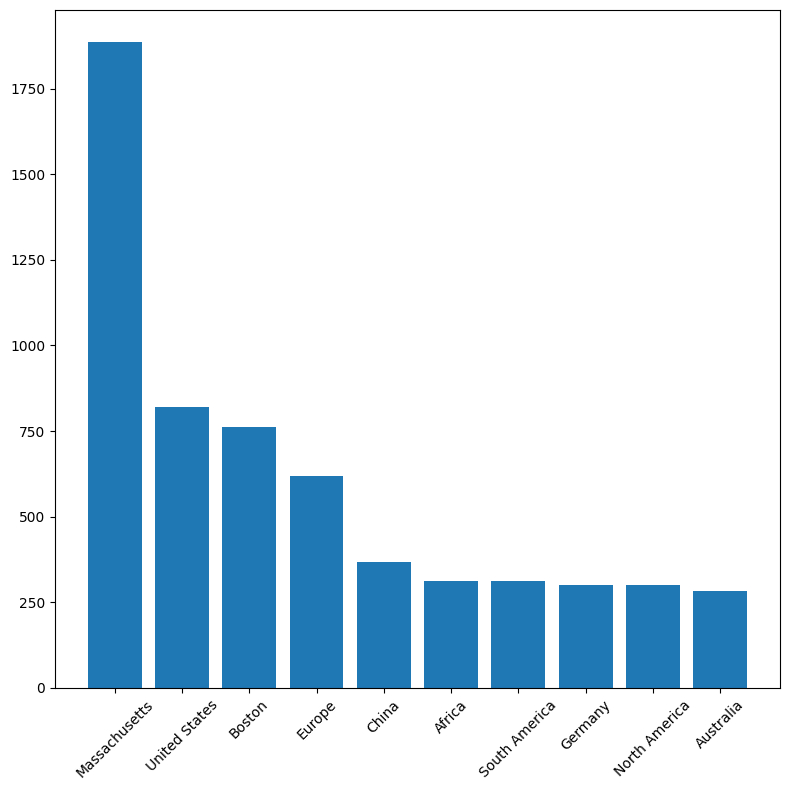

In [10]:
top_10 = spatial_counts.most_common(10)

# Extract the keys and counts
top_keys = [key for key, _ in top_10]
top_values = [value for _, value in top_10]

# Create bar plot with the top 10 counts
plt.figure(figsize = (8, 8))
plt.bar(top_keys, top_values)
plt.xticks(rotation = 45)
plt.tight_layout()

### A simple approach to summarizing subject data -- How many occurrences of each string? ('subject')

In [11]:
subject_counts = Counter([string for sublist in df['subject'] for string in sublist])

print("Subject Counts:")
for string, count in subject_counts.items():
    print(f"{string}: {count}")

Subject Counts:
Maps: 3294
Transportation: 2930
Railroads: 235
Human settlements: 3117
Cities and towns: 2736
Land use: 2318
Landforms: 2683
Infrastructure Economics: 1958
Bodies of water: 3167
imageryBaseMapsEarthCover: 4337
transportation: 1771
Boundaries: 2723
Administrative and political divisions: 733
boundaries: 3868
intelligenceMilitary: 276
structure: 1435
inlandWaters: 868
Census: 4181
Rivers: 540
Airports: 427
Water: 312
Parks: 249
Camp sites: 206
Military installations: 165
Recreation areas: 237
Landmarks: 171
Election districts: 207
Polling places: 91
Political divisions: 340
Maps, Topographic: 635
Early maps: 113
Floods: 102
Flood forecasting: 56
Floodplains: 104
Flood insurance: 56
DFIRM: 57
FIRM: 57
FEMA Flood Hazard Zone: 57
DFIRM Database: 57
Special Flood Hazard Area: 57
Digital Flood Insurance Rate Map: 57
CBRS: 57
Coastal Barrier Resources System: 57
Riverine Flooding: 57
Coastal Flooding: 57
NFIP: 57
Base Flood Elevation: 57
SFHA: 57
Flood Insurance Rate Map: 57
Fl

### Counts above 100, represented in a bar plot ('subject')
Higher threshold because subject have a constrained vocabulary

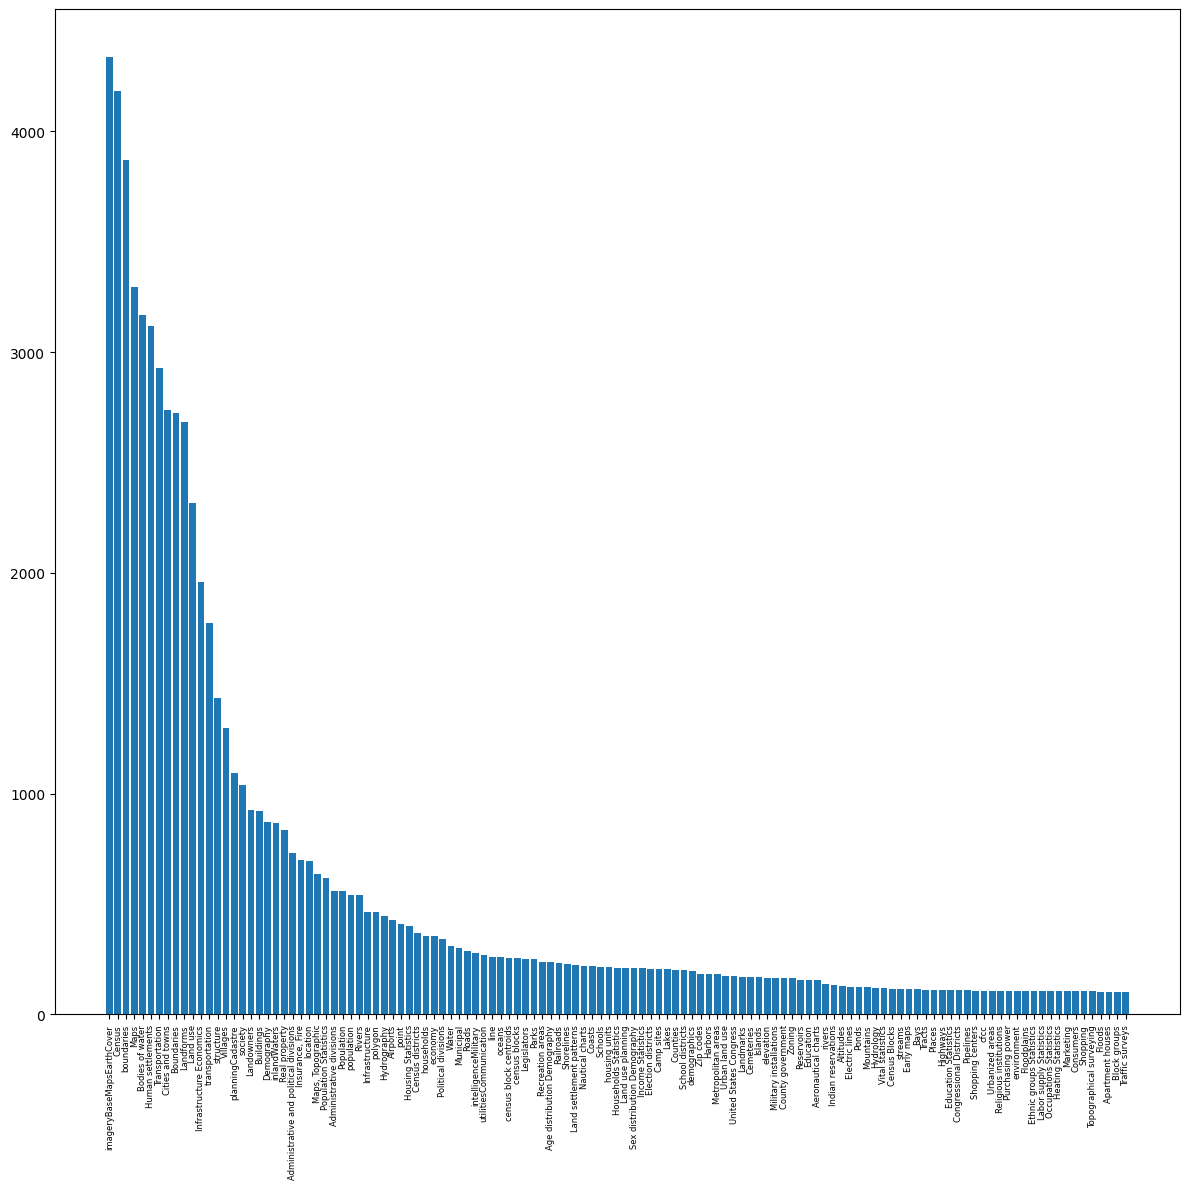

In [12]:
# Trim and sort Counter object to make bar graph viewable
trim_threshold = 100
trimmed_subject = Counter({key: count for key, count in subject_counts.items() if count > trim_threshold})
sorted_subject = sorted(trimmed_subject.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted keys and counts
sorted_keys = [key for key, _ in sorted_subject]
sorted_values = [value for _, value in sorted_subject]

# Plot
plt.figure(figsize = (12, 12))
plt.bar(sorted_keys, sorted_values)
plt.xticks(rotation = 90, fontsize = 6)
plt.tight_layout()

### Zooming into the Top 10 ('subject')

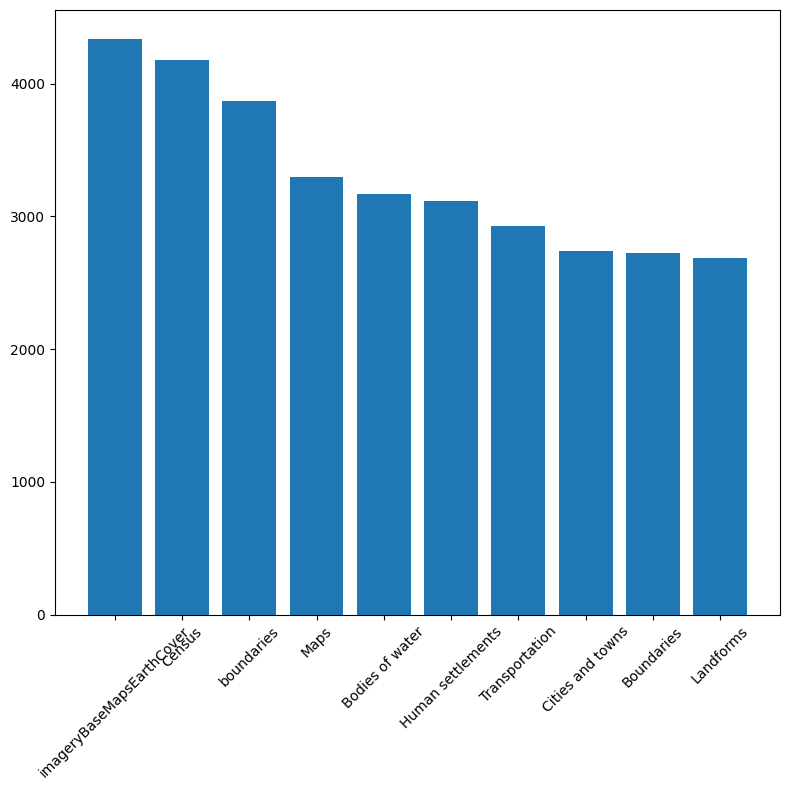

In [13]:
top_10 = subject_counts.most_common(10)

# Extract the keys and counts
top_keys = [key for key, _ in top_10]
top_values = [value for _, value in top_10]

# Create bar plot with the top 10 counts
plt.figure(figsize = (8, 8))
plt.bar(top_keys, top_values)
plt.xticks(rotation = 45)
plt.tight_layout()